# Earthquake as a triggering factor of an infinite slope mechanism

© 2024 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/infinite_slope_earthquake.ipynb).


This notebook runs the model ``pyNermarkDisp`` developed by [Montoya-Araque et al., (2024)](https://doi.org/10.1016/j.envsoft.2024.105942) based on the classical sliding rigid block method by [Newmark (1965)](https://doi.org/10.1680/geot.1965.15.2.139).

## Required modules and global setup for plots

In [1]:
import os
import sys
import subprocess

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    subprocess.run('pip install ipympl', shell=True);
    subprocess.run('pip install pynewmarkdisp', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pynewmarkdisp.newmark import direct_newmark, plot_newmark_integration
from pynewmarkdisp.infslope import factor_of_safety, get_ky
from pynewmarkdisp.spatial import load_ascii_raster, map_zones, plot_spatial_field, spatial_newmark, get_idx_at_coords, verify_newmark_at_cell


%matplotlib widget

# plt.style.use("default")
mpl.rcParams.update(
    {
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

## Basic example

### Loading earthquake record and spatial data

In [2]:
url = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/pynewmarkdisp/"

# Loading earthquake data
earthquake_record = pd.read_csv(f"{url}earthquake_data_simple.csv", sep=";")
earthquake_record = pd.read_csv(f"{url}earthquake_data_simple.csv", sep=";")
g = 1.0  # It means, accel units are given in fractions of gravity
accel = np.array(earthquake_record["Acceleration"])
time = np.array(earthquake_record["Time"])

zones = np.array([[1]])  # [] ID of the zone to match with `parameters`
dem = np.array([[1]])  # [msnm] Digital elevation model for one cell model
slope = np.array([[40]])  # [°]
depth = np.array([[1]])  # [m]
depth_w = np.array([[1]])  # [m]

### Non-spatial inputs

In [3]:
# Geotechnical parameters for each geological zone
parameters = {1: (30, 5, 20)}  # Zone ID: (𝜙' [°], 𝑐' [kPa], 𝛾 [kN/m³])

# Associating geotechnical parameters to each geological zone spatially and plotting
phi, c, gamma = map_zones(parameters, zones)

### Calculating $\mathrm{FS}_\mathrm{static}$

In [4]:
fs = factor_of_safety(depth, depth_w, slope, phi, c, gamma, ks=0)
print(f"Static factor of safety: {fs:.2f}")

Static factor of safety: 1.20


### Calculating $k_\mathrm{y}$

In [5]:
ky = get_ky(depth, depth_w, slope, phi, c, gamma)
print(f"Critical seismic coefficient, ky: {ky:.2f}")

Critical seismic coefficient, ky: 0.11


### Calculating $\mathrm{FS}_\mathrm{pseudostatic}$ when $k_\mathrm{s}$ is 40% of $k_\mathrm{y}$

In [6]:
ks = 0.4 * ky
fs_ks = factor_of_safety(depth, depth_w, slope, phi, c, gamma, ks=ks)
print(f"Pseudostatic factor of safety: {fs_ks:.2f}")

decrease_fs = (fs - fs_ks) / fs * 100
print(f"Decrease in factor of safety: {decrease_fs:.2f} %")

Pseudostatic factor of safety: 1.11
Decrease in factor of safety: 7.11 %


### Calculating and plotting $u_\mathrm{p}$

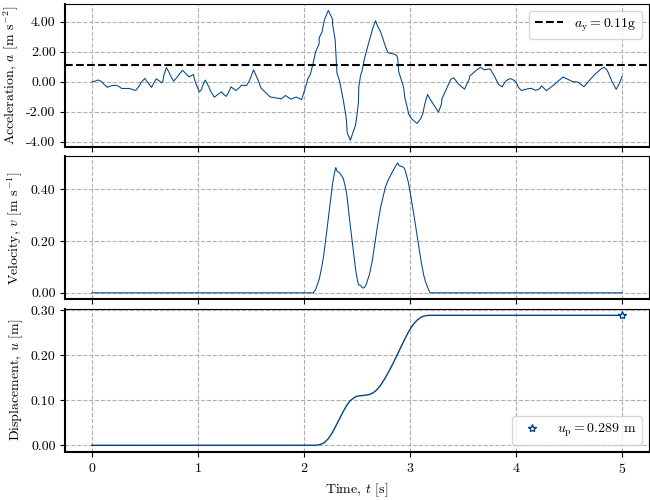

In [7]:
permanent_disp = direct_newmark(time, accel, ky, g)
fig = plot_newmark_integration(permanent_disp)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

## Loading record from an external file

### Creating directories

In [8]:
# Create a folder called TRIGRS in the current working directory if it doesn't exist
workdir = os.getcwd()
records_dir = os.path.join(workdir, "records")
os.makedirs(f"{records_dir}", exist_ok=True)

### Functions to calculate some intensity measures

In [9]:
def get_arias_intensity(time, accel, g):
    return np.trapz(y=accel**2, x=time) * np.pi / (2 * g)

def get_pgv(time, accel, g):
    accel = 9.81 * accel / g  # Earthquake acceleration to SI units
    vel = np.cumsum(accel) * (time[1] - time[0])
    return np.max(np.abs(vel))

def get_pga(accel, g):
    accel = 9.81 * accel / g  # Earthquake acceleration to SI units
    return np.max(np.abs(accel))

In [10]:
def load_file():
    if 'google.colab' in str(get_ipython()):
        file = files.upload()
        # Move the file to the records folder
        os.rename(list(file.keys())[0], os.path.join(records_dir, list(file.keys())[0]))
        record = np.loadtxt(os.path.join(records_dir, list(file.keys())[0]))
    else:
        tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
        file = askopenfilename()
        # Move the file to the records folder
        os.rename(file, os.path.join(records_dir, os.path.basename(file)))
        record = np.loadtxt(os.path.join(records_dir, os.path.basename(file)))
    return record

### Loading records files

In [11]:
record = load_file()
# Extracting time and acceleration from the record
time, accel = record.T
time, accel

(array([0.0000e+00, 5.0000e-03, 1.0000e-02, ..., 3.3860e+01, 3.3865e+01,
        3.3870e+01]),
 array([ 0.        ,  0.00257009,  0.00171369, ..., -0.00082859,
        -0.00071695, -0.00060462]))

### Calculating and plotting $u_\mathrm{p}$

In [12]:
g = 9.81  #  → It means that acceleration units in the input file are given in [m/s²]
arias_intensity = get_arias_intensity(time, accel, g)  # [m/s]
pgv = get_pgv(time, accel, g)  # [m/s]
pga = get_pga(accel, g)/g  # [g]

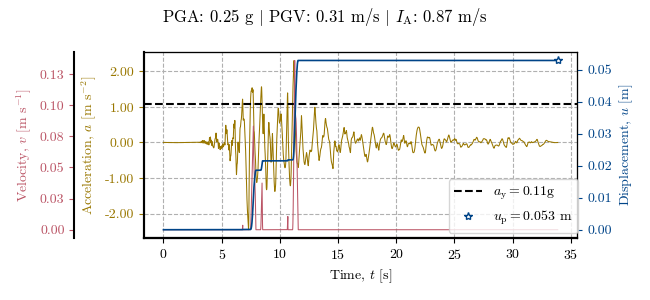

In [13]:
permanent_disp = direct_newmark(time, accel, ky, g)
fig = plot_newmark_integration(permanent_disp, compressed=True)
fig.suptitle(f"PGA: {pga:.2f} g $|$ PGV: {pgv:.2f} m/s $|$ $I_\\mathrm{{A}}$: {arias_intensity:.2f} m/s")
fig.tight_layout()
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()